# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_train_raw = pd.read_csv('../DATA/train.csv' , low_memory=False)
df_store_raw = pd.read_csv('../DATA/store.csv' , low_memory=False)

# Merge
df_raw= pd.merge(df_train_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
464334,165,7,2014-05-11,0,0,0,0,0,0,a,a,3720.0,4.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 1.0. DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [7]:
cols_old = ['Loja', 'DiaDaSemana', 'Data', 'Vendas', 'Clientes', 'Aberto', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Variedade',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old) )

# Rename
df1.columns = cols_new

## 1.2 Data dimensions 

In [8]:
print( 'Nubers of Rows: {}' .format( df1.shape[0] ) )
print( 'Nubers of Cols: {}' .format( df1.shape[1] ) )

Nubers of Rows: 1017209
Nubers of Cols: 18


## 1.3 Data types 

In [9]:
df1['data'] = pd.to_datetime( df1 [ 'data'] )

df1.dtypes

loja                                     int64
dia_da_semana                            int64
data                            datetime64[ns]
vendas                                   int64
clientes                                 int64
aberto                                   int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
variedade                               object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

loja                                 0
dia_da_semana                        0
data                                 0
vendas                               0
clientes                             0
aberto                               0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
variedade                            0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA 

In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
    
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['data'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
    
#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['data'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
    
#promo2_since_week         
df1['promo2_since_week'] = df1.apply( lambda x: x['data'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
    
#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['data'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval             
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )
   
df1['month_map'] = df1['data'].dt.month.map( month_map )
 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
   

In [12]:
df1.isna().sum()

loja                            0
dia_da_semana                   0
data                            0
vendas                          0
clientes                        0
aberto                          0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
variedade                       0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descreptive statistics

In [14]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

## 1.7.1. Numerical Atributes

In [16]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,loja,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,dia_da_semana,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,vendas,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,clientes,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,aberto,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


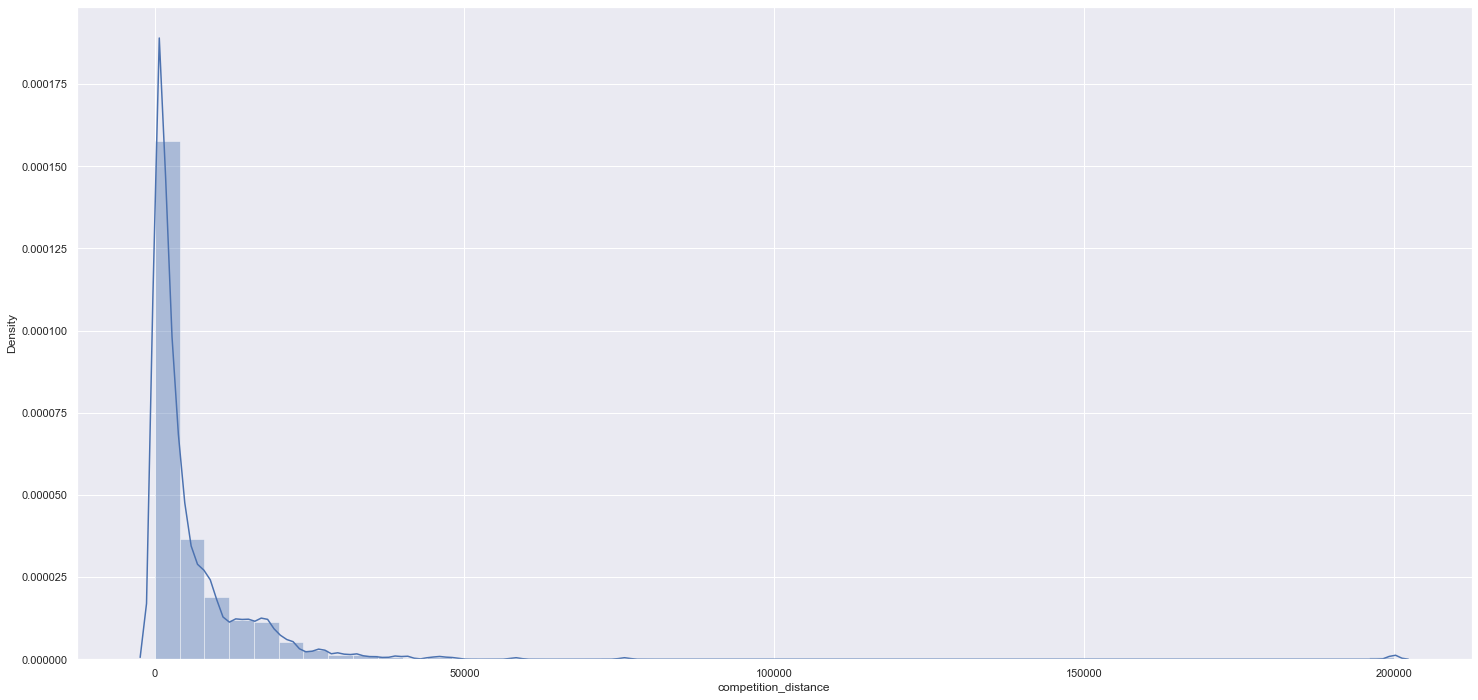

In [18]:
sns.distplot( df1['competition_distance'] );

## 1.7.2. Categorical Atributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
variedade                        3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

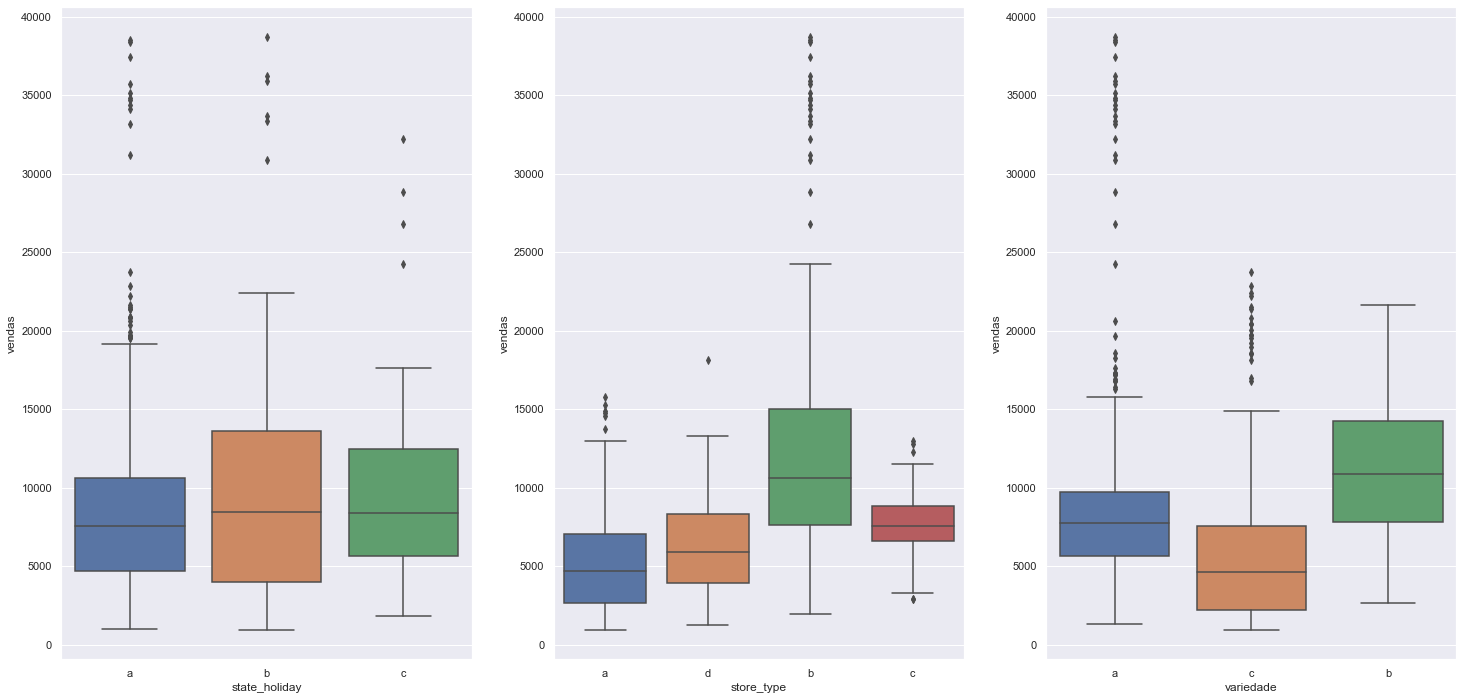

In [20]:
aux = df1[(df1['state_holiday'] != '0') & (df1['vendas'] > 0)]

plt.subplot( 1, 3, 1 );
sns.boxplot( x='state_holiday', y='vendas', data=aux );

plt.subplot( 1, 3, 2 );
sns.boxplot( x='store_type', y='vendas', data=aux );

plt.subplot( 1, 3, 3 );
sns.boxplot( x='variedade', y='vendas', data=aux );

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

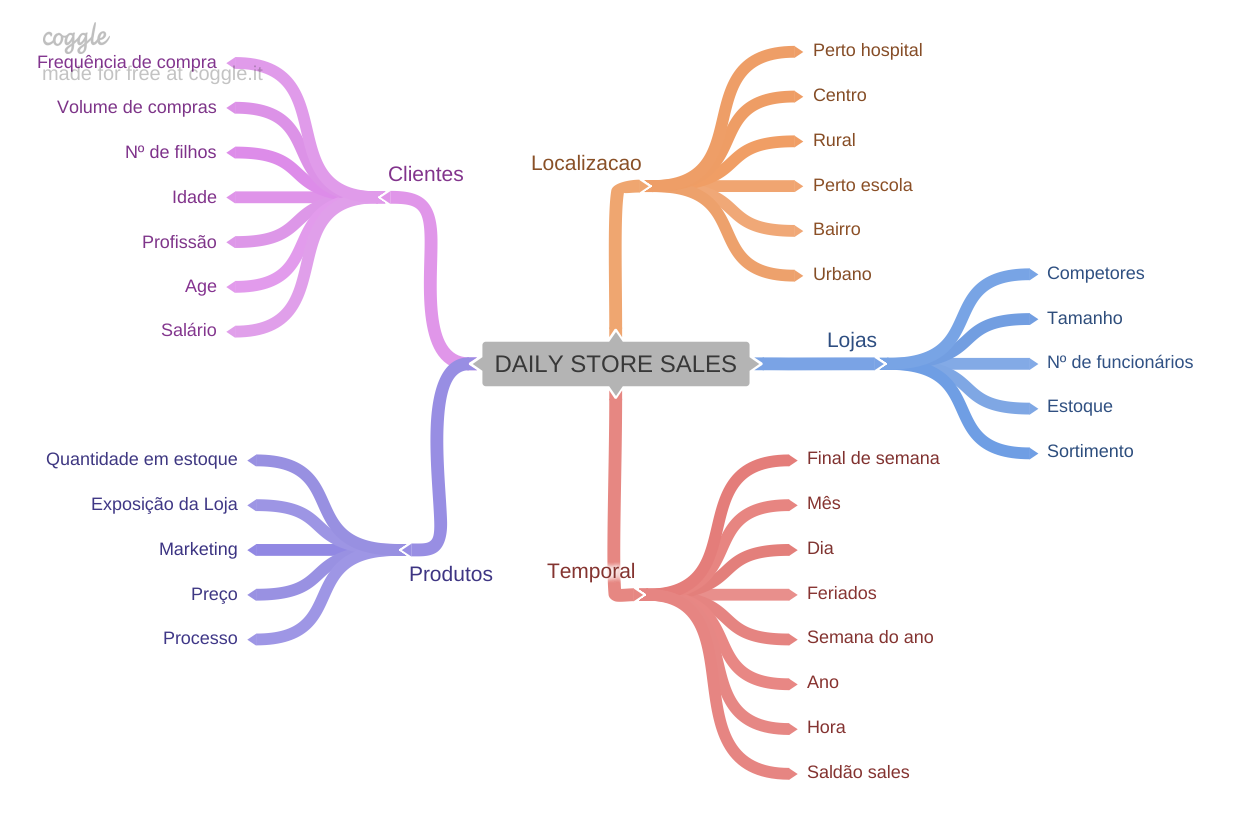

In [22]:
Image('../Img/mind_map.png')

## 2.2 Criação das hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com múmero maior de funcionários deveriam vender mais.

**2.** Lojas coom maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveiram vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto 

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos de menor preço deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.3.3 Hipóteses de Tempo 

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Lista final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**5.** Lojas com mais dias de promoção deveriam vender mais. 

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre. 

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

 **11.** Lojas deveriam vender menos finais de semana.
 
 **13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [23]:
# year
df2['year'] = df2['data'].dt.year
# month
df2['month'] = df2['data'].dt.month
# day
df2['day'] = df2['data'].dt.day
# week of year
df2['week_of_year'] = df2['data'].dt.weekofyear
# year week
df2['year_week'] = df2['data'].dt.strftime( '%Y-%W' )



# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(␣
,→year=x['competition_open_since_year'],␣
,→month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['data'] - df2['competition_since'] )/30␣
,→).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' +␣
,→df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.
,→strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['data'] - df2['promo_since'] )/7 ).apply(␣
,→lambda x: x.days ).astype( int )



# Variedade
df2['variedade'] = df2['variedade'].apply( lambda x: 'basic' if x == 'a' else␣
,→'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday'␣
,→if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c'␣
,→else 'regular_day' )


SyntaxError: invalid character '␣' (U+2423) (Temp/ipykernel_10860/144475894.py, line 15)

# 3.0. FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [27]:
df3.head(1)

,loja,dia_da_semana,data,vendas,clientes,aberto,promo,state_holiday,school_holiday,store_type,variedade,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0


## 3.1 Filtragem das linhas

In [33]:
df3 = df3[ ( df3['aberto']!= 0 ) & ( df3 ['vendas'] > 0 ) ]

## 3.2 Seleção das colunas

In [34]:
cols_drop = [ 'clientes', 'aberto', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

In [35]:
df3.columns

Index(['loja', 'dia_da_semana', 'data', 'vendas', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'variedade', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

# 4.0.  ANÁLISE EXPLORATÓRIA DOS DADOS

In [36]:
df4 = df3.copy()